<span style="font-family:Trebuchet MS; font-size:2em;">Project 3 | NB2: Cleaning (and some initial EDA)</span>

Riley Robertson | Reddit Classification Project | 

## Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import time
import re

import utilities.densmore as dns

## Other Setup

In [2]:
pd.set_option('display.max_colwidth', None)

## Subreddit info

In [3]:
nfl = 'nfl'
epl = 'PremierLeague'
subs = [nfl, epl]

---

## Reading in CSV files from data collection

In [4]:
df_nfl = pd.read_csv('../git_ignore/output/raw_nfl_v4.csv', low_memory=False)
df_epl = pd.read_csv('../git_ignore/output/raw_epl_v4.csv', low_memory=False)

In [5]:
df_nfl.shape, df_epl.shape

((99661, 13), (99589, 13))

In [6]:
df_nfl_full = pd.read_csv('../git_ignore/output/raw_nfl_v4_full.csv', low_memory=False)
df_epl_full = pd.read_csv('../git_ignore/output/raw_epl_v4_full.csv', low_memory=False)

In [7]:
df_nfl_full.shape, df_epl_full.shape

((99661, 101), (99589, 93))

#### Merging the DataFrames

In [8]:
df = pd.concat([df_epl, df_nfl], ignore_index=True)

In [9]:
df_full = pd.concat([df_epl_full, df_nfl_full], ignore_index=True)

#### Checks

In [10]:
# df.shape
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199250 entries, 0 to 199249
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   index            199250 non-null  int64 
 1   subreddit        199250 non-null  object
 2   created_utc      199250 non-null  int64 
 3   author           199250 non-null  object
 4   num_comments     199250 non-null  int64 
 5   score            199250 non-null  int64 
 6   is_self          199250 non-null  bool  
 7   link_flair_text  29684 non-null   object
 8   title            199250 non-null  object
 9   selftext         168312 non-null  object
 10  full_link        199250 non-null  object
 11  date             199250 non-null  object
 12  time             199250 non-null  object
dtypes: bool(1), int64(4), object(8)
memory usage: 18.4+ MB


**Quick selection and reordering of columns**

In [11]:
df = df[['subreddit', 'created_utc', 'link_flair_text', 'score', 'num_comments', 'index',  'title', 'selftext']]

In [12]:
# df.info()

In [13]:
df['subreddit'].value_counts()

nfl              99661
PremierLeague    99589
Name: subreddit, dtype: int64

After my earliest scrapes of my subreddits, I began cleaning and realized that I was quickly running of posts that that had the conditions I wanted. I returned to my Data Collection notebook and increased the number of posts to request from the API. That way, I would begin my cleaning with a much greater volume of posts than I would eventually need and I'd be able to be a little more decisive with my decisions to drop rows rather than trying to salvage content from posts that didn't have the quality of content I'm looking for.

## Basic Cleaning

#### Nulls

Nulls only exist in two columns: `link_flair_text` and `selftext`. 

I want to remove all posts with an empty selftext field, but don't want to hold on to the posts without tags (there are many). So I'll put 'none' into the empty flair_text fields and then remove all rows with nulls after that.

In [14]:
df['link_flair_text'].fillna('none', inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199250 entries, 0 to 199249
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   subreddit        199250 non-null  object
 1   created_utc      199250 non-null  int64 
 2   link_flair_text  199250 non-null  object
 3   score            199250 non-null  int64 
 4   num_comments     199250 non-null  int64 
 5   index            199250 non-null  int64 
 6   title            199250 non-null  object
 7   selftext         168312 non-null  object
dtypes: int64(4), object(4)
memory usage: 12.2+ MB


In [16]:
df.dropna(inplace=True)
df.shape

(168312, 8)

In [17]:
df['subreddit'].value_counts()

PremierLeague    86351
nfl              81961
Name: subreddit, dtype: int64

#### Duplicates

In [18]:
df.drop_duplicates(inplace=True)
df.shape

(168312, 8)

In [19]:
df['subreddit'].value_counts()

PremierLeague    86351
nfl              81961
Name: subreddit, dtype: int64

`df.drop_duplicates` didn't appear to make any difference to the DataFrame, but there were still some duplicates in the dataframe (based on the title field alone). For example, there were posts with identical title and author, but differences in other fields like the number of comments, which protected them from the simple `df.drop_duplicates`. 

Aderinsola and I worked together to find a way to truly delete all duplicates by separating the title column from the rest, deleting duplicates, and then removing the remaining rows from a second DataFrame so we had a list of all the duplicate posts. We were then able to use the index numbers from the newly trimmed DataFrame as the list of index values to drop from the main DataFrame.

In [20]:
# creating two copies of the dataframe that only have the index and 'title' column
        # df_title_dupes1 = pd.DataFrame(df['title'])
        # df_title_dupes2 = pd.DataFrame(df['title'])
        # df_title_dupes1.shape, df_title_dupes2.shape
    
# finding the duplicates inside of the first copy dataframe
        # df_title_dupes1[df_title_dupes1.duplicated() == True]

# dropping the duplicates from the first list
        # df_title_dupes1.drop_duplicates(inplace=True)
    
# using the index of the first df to drop the non-duplicated rows from the second df
        # df_title_dupes2.drop(axis= 0, labels  = df_title_dupes1.index, inplace=True)

# checking the shape/length of both dfs
        # df_title_dupes1.shape, df_title_dupes2.shape

# using the index of the second df (which contains only the duplicates) to drop
# all duplicated rows from the main df
        # df.drop(axis= 0, labels  = df_title_dupes2.index, inplace=True)
    
# checking final shape of the main df
        # df.shape

After all of that, we discovered the "subset" argument for the `df.drop_duplicates` method..... 

In [21]:
df.drop_duplicates(subset=['selftext', 'title'], inplace=True)
df.shape

(60495, 8)

In [22]:
df['subreddit'].value_counts()

nfl              53831
PremierLeague     6664
Name: subreddit, dtype: int64

Dropping duplicates brings down our PremierLeague posts to a good range, but the number of NFL posts is still much greater than necessary. As I move forward, I'll work on bringing down the number of NFL posts to at least roughly match that of the PremierLeague posts.

#### Replacing code with spaces

For simplicity, I'm replacing the code for various symbols with spaces. This will help me get at clean tokens when I get to the point of tokenizing and vectorizing for analysis.

My first attempts to replace the shortcodes failed, so I went online and found a good solution using simple RegEx.

In [23]:
# This code not working (most likely due to backslash I believe)
# df.replace(to_replace='\n', value=' ', inplace=True)

# https://stackoverflow.com/questions/44227748/removing-newlines-from-messy-strings-in-pandas-dataframe-cells

In [24]:
# \r (return)
df.replace(r'\r',' ', regex=True, inplace=True) 

# \n (line break)
df.replace(r'\n',' ', regex=True, inplace=True)   

# \t (tab)
df.replace(r'\t',' ', regex=True, inplace=True)   

# &amp; (&)
df.replace(r'&amp;',' ', regex=True, inplace=True)   

# &nbsp; (space)
df.replace(r'&nbsp;',' ', regex=True, inplace=True)  

# nbsp; (space, chained to other code)
df.replace(r'nbsp;',' ', regex=True, inplace=True)   

# nbsp; (space, chained to other code)
df.replace(r'#x200B;','', regex=True, inplace=True)   


# # &gt; and &lt; (> and <)
df.replace(r'&lt;',' ', regex=True, inplace=True)   
df.replace(r'&gt;',' ', regex=True, inplace=True) 

# ** (double asterisks for bolding)
df.replace('\*\*', ' ', regex=True, inplace=True) 

I also tried to loop through a list to make this more efficient, but had trouble getting it to work, possibly because the r-strings didn't come through the list correctly or something?

In [25]:
# symbols = [r'&amp;', r'&nbsp;', r'nbsp;', r'&lt;', r'&gt;', '**']

# for symbol in symbols:
#     df.replace(symbol, ' ', regex=True, inplace=True)

In [26]:
# df['selftext'][:20]

There is still cleaning to be done with regard to symbols and symbol code, but I'll circle back to this once I've done more row removal, as I might end up removing the rows that have the problematic text strings.

#### Posts with deleted body text (selftext)

In [27]:
df.drop(axis=0, 
        labels=df[df['selftext'].str.startswith('[deleted]')].index, # Submissions with deleted selftext
        inplace=True)

df['subreddit'].value_counts()

nfl              50938
PremierLeague     6548
Name: subreddit, dtype: int64

### Remove URLs

In [28]:
# def remove_url(text_data):
#     return re.sub(r"http\S+", "", text_data)
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105

In [29]:
# sentence = 'I get help from https://stackoverflow.com and I learn a lot reading on https://towardsdatascience.com'

In [30]:
# remove_url(sentence)

In [31]:
# df['selftext'].map(lambda x: remove_url(x))

In [32]:
# df['selftext'][:20]

## Deep Cleaning

### Repeated Post Titles

#### Overview

Before I got the duplicates removal code working above, I manually went through a list of the most commonly repeating post `'selftext'` and cleared them out with a list and a for-loop. I'm going to remove a bulk of that code since it's no longer necessary, but some of it is still relevant, even after removing duplicates with the code above.

In [33]:
# df['selftext'].value_counts()[:30]

In [34]:
# df.head()

After looking at the value counts for the 'selftext' field, I realized that there were a lot of posts that had the exact same body text. So I used the following code to look at the top 20 most common titles and there were quite a few that were re-used many times. 

In [35]:
# df['title'].value_counts()[:20]

Readable results from above code:

| Post Title                                         | Count | ┃ | Post Title                          | Count | ┃ | Post Title                                   | Count |
|:---------------------------------------------------|:------|:-:|:------------------------------------|:------|:-:|:---------------------------------------------|:------|
| Shitpost Saturday                                  | 174   | ┃ | Talko Tuesday                       | 124   | ┃ | r/PremierLeague Midweek Musings              | 13    |
| Water Cooler Wednesday                             | 159   | ┃ | r/PremierLeague Daily Discussion    | 71    | ┃ | Weekly /r/PremierLeague Subreddit Suggestion | 11    |
| Free Talk Friday                                   | 158   | ┃ | This Week's Top /r/NFL [Highlight]s | 22    | ┃ | Test                                         | 11    |
| Sunday Brunch                                      | 157   | ┃ | Weekend Wrap Up                     | 21    | ┃ | Daily Open Discussion Thread                 | 11    |
| Thursday Talk Thread... Yes That's The Thread Name | 141   | ┃ | Question                            | 15    | ┃ | Weekly Transfer Discussion Thread            | 8     |
| Weekend Wrapup                                     | 130   | ┃ | NFL Power Rankings (Combined)       | 15    | ┃ | test                                         | 7     |

They fell into several categories:
1. Open threads meant for discussion of topics of any kind, even if unrelated to the topic of the subreddit.
2. Discussion threads in which the topics might be related, but all of the content is in the comments rather than the body of the post
3. Posts with code and/or little-to-no useful content
4. Commonly used titles by different users to introduce a topic-relevant post

#### Removing the posts

In [36]:
repeat_titles = ["Shitpost Saturday", "Water Cooler Wednesday", "Free Talk Friday", "Sunday Brunch", 
                 "Thursday Talk Thread... Yes That's The Thread Name", "Weekend Wrapup", "Talko Tuesday",
                 "r/PremierLeague Daily Discussion", "This Week's Top /r/NFL [Highlight]s", 
                 "Weekend Wrap Up", "NFL Power Rankings (Combined)", "r/PremierLeague Midweek Musings", 
                 "Whose Line is it Anyways Wednesday--Offseason Edition", 
                 "Weekly /r/PremierLeague Subreddit Suggestion", "Test", "Daily Open Discussion Thread",
                 "Weekly Transfer Discussion Thread", "test", "Your Weekly /r/nfl Recap", 
                 "NFL Power Rankings (Combined) Week 0",
                 "Should Ole stay at Manchester United or not? If he got sacked by the board, who will be the best replacement. Comment your thoughts below"
                ]

In [37]:
for post in repeat_titles:
    post_df = df[df['title'] == post]  
    df.drop(axis=0, labels=post_df.index, inplace=True)

In [38]:
# df['title'].value_counts()[:20]

In [39]:
df['subreddit'].value_counts()

nfl              50843
PremierLeague     6532
Name: subreddit, dtype: int64

### Tables with Markdown

In [40]:
markdown = df[df['selftext'].str.contains('\|')]

In [41]:
markdown['subreddit'].value_counts()

nfl              4054
PremierLeague     201
Name: subreddit, dtype: int64

In [42]:
df.drop(axis=0, labels=markdown.index, inplace=True)

### PremierLeague Poll Posts

I found 91 posts from the PremierLeague subreddit that contained a lot of unnecessary information and formatting was such that vectorizing would be significantly more complicated. I decided to simply remove them for simplicity.

In [43]:
len('[View Poll](https://www.reddit.com/poll/g437k5)')

47

In [44]:
poll_posts = df[df['selftext'].str.startswith('  [View Poll]')]

In [45]:
poll_posts.shape

(443, 8)

In [46]:
df.drop(axis=0, labels=poll_posts.index, inplace=True)

In [47]:
df['subreddit'].value_counts()

nfl              46786
PremierLeague     5891
Name: subreddit, dtype: int64

### PremierLeague Match Threads

I found 91 posts from the PremierLeague subreddit that contained a lot of unnecessary information and formatting was such that vectorizing would be significantly more complicated. I decided to simply remove them for simplicity.

In [48]:
match_threads = df[df['title'].str.startswith('[Match thread]')]

In [49]:
match_threads.shape

(0, 8)

In [50]:
df.drop(axis=0, labels=match_threads.index, inplace=True)

In [51]:
df['subreddit'].value_counts()

nfl              46786
PremierLeague     5891
Name: subreddit, dtype: int64

### Removing NFL posts with Tags

Game Thread, Serious, Look Here!, and others 

In [52]:
df['link_flair_text'].value_counts()[:10]

none                       48135
Discussion                  1585
Question                     904
Serious                      475
Poll                         264
:xpl: Premier League         237
Look Here!                   178
News                          80
:mun: Manchester United       75
:liv: Liverpool               61
Name: link_flair_text, dtype: int64

In [53]:
nfl_with_tags = df[(df['link_flair_text'] != 'none') & (df['subreddit'] == 'nfl')]
df.drop(axis=0, labels=nfl_with_tags.index, inplace=True)

In [54]:
df['link_flair_text'].value_counts()[:10]

none                       48135
Discussion                  1585
Question                     904
Poll                         264
:xpl: Premier League         237
News                          80
:mun: Manchester United       75
:liv: Liverpool               61
:ars: Arsenal                 58
:che: Chelsea                 51
Name: link_flair_text, dtype: int64

In [55]:
df.drop(axis=0, labels=df[(df['link_flair_text'] == 'Poll')].index, inplace=True)

df['subreddit'].value_counts()

nfl              45927
PremierLeague     5627
Name: subreddit, dtype: int64

### NFL Posts Filtered by String Length

In [56]:
df_filtered = df[df['subreddit'] == 'nfl']
df_filtered.shape

(45927, 8)

In [57]:
df_lengthlimits = df[(df['selftext'].str.len()>500) & (df['selftext'].str.len()<1200) & (df['subreddit'] == 'nfl')]
df_lengthlimits.shape

(7327, 8)

In [58]:
df_filtered.drop(axis=0, labels=df_lengthlimits.index, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [59]:
df_filtered.shape

(38600, 8)

In [60]:
df.drop(axis=0, labels=df_filtered.index, inplace=True)

In [61]:
df['subreddit'].value_counts()

nfl              7327
PremierLeague    5627
Name: subreddit, dtype: int64

### Investigating Post Lengths and Word Counts

In [62]:
df['post_length'] = df['selftext'].map(lambda x: len(x))

In [63]:
df['post_word_count'] = df['selftext'].map(lambda x: len(x.split(' ')))

In [64]:
pd.reset_option('display.max_colwidth')
df.head()

,subreddit,created_utc,link_flair_text,score,num_comments,index,title,selftext,post_length,post_word_count
1,PremierLeague,1619261612,Discussion,1,164,1,One day I hope Mourinho will go somewhere wher...,Everyone raves about defence being his strateg...,237,38
2,PremierLeague,1619265233,Question,1,3,2,What's the best place to watch Premier league ...,There's a few on YouTube but I want to be able...,211,44
3,PremierLeague,1619265483,Discussion,1,1,3,Forget obsessing about the ESL... the REAL pro...,Forget obsessing about the ESL... the ...,1294,277
5,PremierLeague,1619271210,:liv: Liverpool,1,16,5,Tough day to be a Liverpool supporter. 22 shot...,Liverpool’s shooting was appalling to be compl...,113,21
6,PremierLeague,1619271257,:xpl: Premier League,1,2,6,Justice served. Fuck VAR,I can’t believe that they dissallowed Wilson’s...,554,101


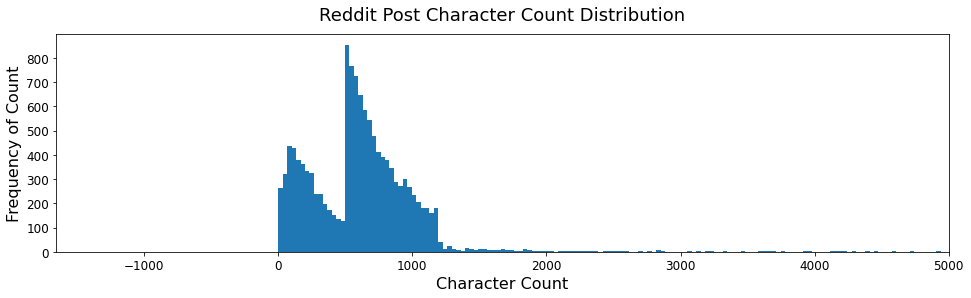

In [65]:
plt.figure(figsize = (16,4))

plt.hist(df['post_length'],bins=1000)

# plt.xlim(left=1000)
plt.xlim(right=5000)
# plt.ylim(top=20)

plt.title('Reddit Post Character Count Distribution', size = '18', pad = '14')

plt.xlabel('Character Count', size = 16)
plt.xticks(size = 12)

plt.ylabel('Frequency of Count', size = 16)
plt.yticks(size = 12);

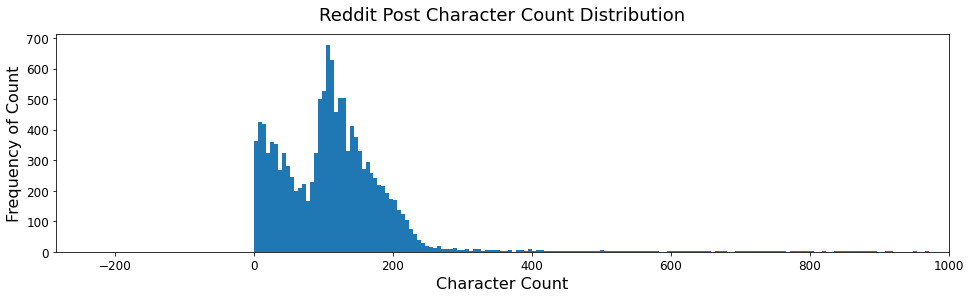

In [66]:
plt.figure(figsize = (16,4))

plt.hist(df['post_word_count'],bins=1000)

# plt.xlim(left=1000)
plt.xlim(right=1000)
# plt.ylim(top=20)

plt.title('Reddit Post Character Count Distribution', size = '18', pad = '14')

plt.xlabel('Character Count', size = 16)
plt.xticks(size = 12)

plt.ylabel('Frequency of Count', size = 16)
plt.yticks(size = 12);

### Date Trimming

In [67]:
df['datetime'] = df['created_utc'].map(lambda x: dt.datetime.fromtimestamp(x))

In [68]:
df.head(1)

,subreddit,created_utc,link_flair_text,score,num_comments,index,title,selftext,post_length,post_word_count,datetime
1,PremierLeague,1619261612,Discussion,1,164,1,One day I hope Mourinho will go somewhere wher...,Everyone raves about defence being his strateg...,237,38,2021-04-24 03:53:32


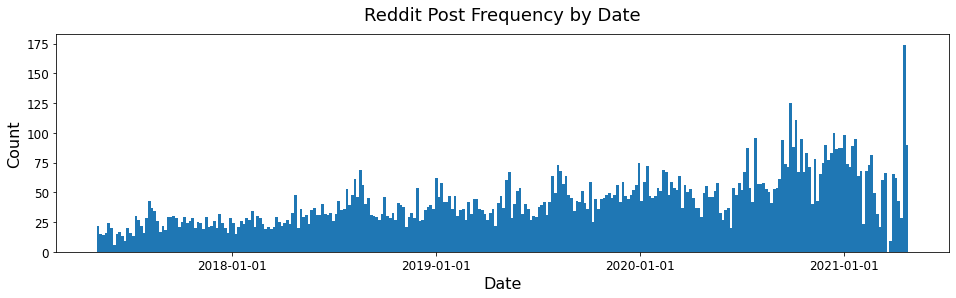

In [69]:
plt.figure(figsize = (16,4))

plt.hist(df['datetime'],bins=300)

plt.title('Reddit Post Frequency by Date', size = '18', pad = '14')

plt.xlabel('Date', size = 16)
plt.xticks(ticks=['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01'], size = 12)

plt.ylabel('Count', size = 16)
plt.yticks(size = 12);

Combined, the NFL and EPL posts span a number of years - as far back as mid 2017. There's a gentle increase in post count over time, but for the most part, the changes aren't dramatic. Our spread of posts seems good, offering a wide sample of data.

In [70]:
df['subreddit'].value_counts()

nfl              7327
PremierLeague    5627
Name: subreddit, dtype: int64

In [71]:
df_nfl_dates = df[df['subreddit'] == nfl]

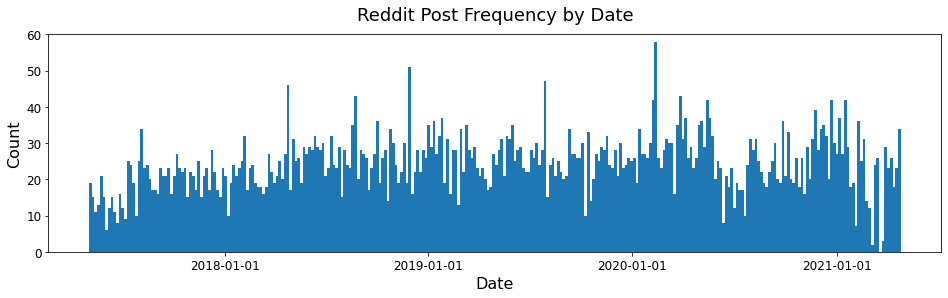

In [72]:
plt.figure(figsize = (16,4))

plt.hist(df_nfl_dates['datetime'],bins=300)

plt.ylim(top=60)

plt.title('Reddit Post Frequency by Date', size = '18', pad = '14')

plt.xlabel('Date', size = 16)
plt.xticks(ticks=['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01'], size = 12)

plt.ylabel('Count', size = 16)
plt.yticks(size = 12);

By itself, the NFL posts are very even across the timeline.  
The changes we saw in the graph above are likely from the EPL posts, which we can investigate next.

In [73]:
df_epl_dates = df[df['subreddit'] == epl]

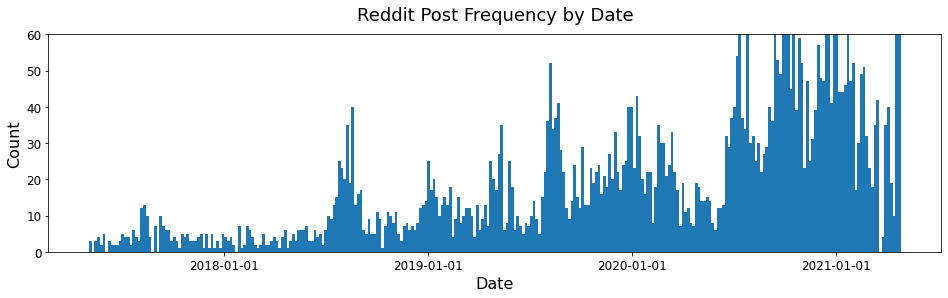

In [74]:
plt.figure(figsize = (16,4))

plt.hist(df_epl_dates['datetime'],bins=300)

plt.ylim(top=60) 

plt.title('Reddit Post Frequency by Date', size = '18', pad = '14')

plt.xlabel('Date', size = 16)
plt.xticks(ticks=['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01'], size = 12)

plt.ylabel('Count', size = 16)
plt.yticks(size = 12);

As suspected, there is a far less consistency in post volume over time, quite possibly due to the kinds of posts I removed during the cleaning process. I limited the y axis on both charts to 60 for the sake of comparison. The least-represented data is EPL posts from 2017 through most of 2019. I don't think the lack of consistency will cause a problem in our analysis, but I can always come back and adjust my cleaning process to retain a larger number of posts from the PremierLeague subreddit.

### Re-Indexing

After removing so many rows, the DataFrame's index had gaps in its sequencing, so I decided to reset it to clean it up.

In [75]:
pd.reset_option('display.max_colwidth')

In [76]:
df[5:9]

,subreddit,created_utc,link_flair_text,score,num_comments,index,title,selftext,post_length,post_word_count,datetime
7,PremierLeague,1619271770,Discussion,1,3,7,My thoughts and prayers are with Jurgen Klopp ...,"Imagine being Jurgen Klopp right now, arguably...",1211,221,2021-04-24 06:42:50
9,PremierLeague,1619278607,Discussion,1,2,9,Premier League Players who should finish off t...,Chinese Super League is known to be the last p...,603,115,2021-04-24 08:36:47
14,PremierLeague,1619283368,Question,1,8,14,"Hypothetical situation, what happens if both c...","So let’s say this season, arsenal win the euro...",194,40,2021-04-24 09:56:08
15,PremierLeague,1619283692,Question,1,24,15,"Norwich, Watford, and Bournemouth might all ge...",Norwich and Watford have already been promoted...,185,31,2021-04-24 10:01:32


The 'index' column can serve as a record of each posts original index number in case it's ever needed going forward.

In [77]:
df.reset_index(drop=True, inplace=True)

In [78]:
df[5:9]

,subreddit,created_utc,link_flair_text,score,num_comments,index,title,selftext,post_length,post_word_count,datetime
5,PremierLeague,1619271770,Discussion,1,3,7,My thoughts and prayers are with Jurgen Klopp ...,"Imagine being Jurgen Klopp right now, arguably...",1211,221,2021-04-24 06:42:50
6,PremierLeague,1619278607,Discussion,1,2,9,Premier League Players who should finish off t...,Chinese Super League is known to be the last p...,603,115,2021-04-24 08:36:47
7,PremierLeague,1619283368,Question,1,8,14,"Hypothetical situation, what happens if both c...","So let’s say this season, arsenal win the euro...",194,40,2021-04-24 09:56:08
8,PremierLeague,1619283692,Question,1,24,15,"Norwich, Watford, and Bournemouth might all ge...",Norwich and Watford have already been promoted...,185,31,2021-04-24 10:01:32


### Column Clean-up

**Renaming `'selftext'` to `'post'`**

In [79]:
df['post'] = df['selftext']

In [80]:
df.drop(columns='selftext', inplace=True)

**Renaming `'num_comments'` to `'comments'`**

Shortening column name

In [81]:
df['comments'] = df['num_comments']

In [82]:
df.drop(columns='num_comments', inplace=True)

**Renaming `'link_flair_text'` to `'tag'`**

In [83]:
df['tag'] = df['link_flair_text']

In [84]:
df.drop(columns='link_flair_text', inplace=True)

**Re-ordering columns**

In [85]:
df = df[['subreddit', 'datetime', 'score', 'comments', 'index', 'tag', 'title', 'post']]

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   subreddit  12954 non-null  object        
 1   datetime   12954 non-null  datetime64[ns]
 2   score      12954 non-null  int64         
 3   comments   12954 non-null  int64         
 4   index      12954 non-null  int64         
 5   tag        12954 non-null  object        
 6   title      12954 non-null  object        
 7   post       12954 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 809.8+ KB


In [87]:
df['subreddit'].value_counts()

nfl              7327
PremierLeague    5627
Name: subreddit, dtype: int64

In [88]:
pd.set_option('display.max_colwidth', None)

In [89]:
pd.DataFrame(df.iloc[3311]).T

,subreddit,datetime,score,comments,index,tag,title,post
3311,PremierLeague,2020-02-03 01:42:00,1,0,22134,none,"I often hear commentator say ""Ricky Shade"", but what does it mean?",English is not my first language I am sorry.


---

## Export

In [90]:
df.to_csv('../data/reddit_posts_clean.csv')

In [91]:
df[df['post'].str.len()>2000]

subreddit            datetime  score  comments  index  \
30    PremierLeague 2021-04-22 06:37:15      1         8     52   
37    PremierLeague 2021-04-22 12:16:32      1        15     60   
47    PremierLeague 2021-04-23 07:20:56      1         2     71   
48    PremierLeague 2021-04-23 08:05:22      1       201     72   
49    PremierLeague 2021-04-23 08:12:20      1         6     73   
...             ...                 ...    ...       ...    ...   
5344  PremierLeague 2018-05-09 02:31:42      0         0  53789   
5414  PremierLeague 2018-01-26 12:50:09      2         1  58889   
5475  PremierLeague 2017-10-24 14:17:47      8        10  63589   
5481  PremierLeague 2017-10-17 06:50:30     51       176  63989   
5601  PremierLeague 2017-06-27 22:18:35      6         3  69590   

                       tag  \
30              Discussion   
37              Discussion   
47              Discussion   
48              Discussion   
49    :xpl: Premier League   
...                    ...   
5344                  none   
5414                  none   
5475                  none   
5481                  none   
5601                  none   

                                                                                                                                  title  \
30                                                                                        Salary Caps No Longer Work in Modern Football   
37                                                                         Was the ESL just a huge money laundering/tax evasion scheme?   
47    League and EUFA officials who are upset about the ESL proposal should stop blaming "greedy foreign owners" and look in the mirror   
48            League and UEFA officials who opposed the Super League should stop blaming "greedy foreign owners" and look in the mirror   
49                                                   All that's wrong with football   how it could be fixed - Share your thoughts/ideas   
...                                                                                                                                 ...   
5344                                                                                                     MANCESTER UNITED MID-WEEK NEWS   
5414                                                                                                                      Short-Changed   
5475                                                                                          Can Man City Become The Invincibles 2018?   
5481                                   Friend and I are disenchanted with the NFL. Help us pick a EPL teams? (aka Sell us on your team)   
5601        Fans from the US, please let the FCC know that NBC's new premium streaming plan is unfair to US-based fans of smaller clubs   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       